# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (26332/26332), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3
  - [1, 1, SE, [116]]                 # 2
  - [0, 1, Index, [232, 6]]           # 3: P4
  - [3, 1, SE, [232]]                 # 4
  - [0, 1, Index, [464, 7]]           # 5: P5
  - [5, 1, SE, [464]]                 # 6

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]  # 13
  - [[13, 7], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [64, False]]                  # 15 (256 → 64)

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16
  - [[16, 12], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22

  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 20.0MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.09MB/s]
E0000 00:00:1745417199.323514      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745417199.383297      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   1  1      1624  ultralytics.nn.modules.conv.SE               [116]                         
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1      6496  ultralytics.nn.modules.conv.SE               [232]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  6                   5  1     26912  ultralytics.nn.modules.conv.SE               [464]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 19.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:03<00:00, 140.20it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 139.84it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.69G      3.803      78.48       3.39         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      3.14G      4.361      9.982      2.279         52        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.15G      3.696      4.265      1.466         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        200       1017    0.00413      0.209    0.00836    0.00252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      3.15G      3.412      3.372      1.371         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200       1017      0.391      0.164       0.14     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      3.15G      3.234      2.918      1.284         50        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


                   all        200       1017      0.213       0.16     0.0724     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.15G      3.186      2.692      1.248         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


                   all        200       1017      0.337      0.286      0.188     0.0391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      3.15G      3.089       2.55      1.246         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.366      0.288      0.191     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.15G      2.998      2.291      1.203         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


                   all        200       1017      0.418      0.349      0.274     0.0685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      3.15G      2.973      2.234      1.223         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


                   all        200       1017       0.45      0.308      0.245     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.15G      2.897      2.042      1.194         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.431      0.358      0.256     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      3.15G      2.936      2.037      1.161         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.397      0.333      0.261     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      3.15G      2.906      2.021      1.191         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.415      0.362      0.248     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      3.15G      2.915      1.896      1.197         16        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        200       1017      0.374      0.338      0.223     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      3.15G      2.766      1.814      1.107         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200       1017      0.506      0.423      0.351     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      3.15G       2.73      1.698      1.108         37        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


                   all        200       1017      0.438      0.354      0.288     0.0803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      3.15G      2.789      1.716      1.127         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        200       1017      0.409      0.341       0.27     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      3.15G      2.773      1.656      1.126         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.452      0.346      0.278     0.0671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.15G      2.812      1.644      1.182         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200       1017      0.473      0.367      0.286     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.15G      2.739      1.574      1.139         49        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.469      0.366      0.304     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      3.15G      2.681      1.521      1.107         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.517      0.416      0.365      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      3.15G      2.735      1.486      1.178         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.557      0.387       0.34     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.15G      2.679      1.431      1.129         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.446      0.352        0.3     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.15G      2.683      1.415      1.084         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.523      0.351      0.324     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      3.15G      2.697      1.407      1.098         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.589      0.394      0.383      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      3.15G      2.622      1.383      1.093         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


                   all        200       1017      0.589      0.415      0.394      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.15G      2.578      1.353      1.127         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200       1017      0.513       0.42      0.349      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      3.15G      2.616      1.369      1.086         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.523       0.38      0.356      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.15G      2.578      1.347      1.088         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


                   all        200       1017      0.566      0.434      0.401      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      3.15G      2.623      1.328      1.095         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        200       1017      0.542      0.417      0.379       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.15G      2.598      1.333      1.081         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.535      0.373      0.352      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      3.15G       2.55      1.321      1.144         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        200       1017       0.55      0.426      0.397      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      3.15G      2.553      1.282      1.105         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        200       1017      0.504      0.385      0.331     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      3.15G      2.621      1.296      1.125         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017       0.57      0.381      0.393      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.15G      2.571      1.261      1.076         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.528      0.434      0.382      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.15G      2.582      1.259      1.084         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200       1017      0.573      0.432      0.409      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      3.15G      2.592      1.254      1.043         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200       1017      0.557      0.405      0.371      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.15G      2.536       1.26      1.068         25        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        200       1017       0.49      0.413      0.393      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      3.15G      2.546      1.255      1.081         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.497      0.369      0.342     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      3.15G       2.45      1.228      1.057         25        640: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.563      0.446      0.425      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      3.15G       2.45      1.198      1.089         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.601      0.424      0.418      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      3.15G      2.449      1.185      1.064         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.504      0.415      0.394      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.15G      2.409      1.138      1.084         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.528      0.399      0.387      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      3.15G      2.476      1.162      1.032         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.529      0.401      0.391      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      3.15G      2.393      1.155      1.085         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.578      0.412      0.406      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      3.15G      2.413       1.16      1.024         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200       1017      0.571      0.448      0.426      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      3.15G      2.427       1.16       1.05         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200       1017      0.581      0.409      0.393      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      3.15G      2.441      1.153      1.048         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

                   all        200       1017      0.578      0.431      0.437      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      3.15G      2.468      1.148      1.015         40        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017       0.57      0.426       0.43      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      3.15G      2.425      1.153      1.052         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.565      0.411       0.41      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.15G      2.433      1.146      1.041         56        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200       1017      0.553      0.429      0.421      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      3.15G      2.384      1.117      1.027         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017      0.558      0.431       0.42      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      3.15G      2.373      1.135      1.035         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017      0.501      0.406      0.378      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      3.15G      2.421      1.117      1.014         57        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017        0.6      0.431      0.423      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.15G      2.326      1.103      1.055         33        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        200       1017      0.635      0.441      0.451      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.15G      2.327       1.09      1.088         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1017      0.588      0.427      0.408      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      3.15G      2.444      1.123      1.038         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.606      0.435      0.423      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      3.15G      2.406      1.134      1.034         11        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.595      0.428       0.42       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.15G      2.421      1.105      1.055         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1017      0.508       0.45      0.417      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      3.15G       2.28      1.067       1.04         38        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        200       1017      0.583      0.423      0.437      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      3.15G      2.336      1.085      1.047         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.627       0.45      0.449      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      3.15G      2.332      1.063      1.006         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.627      0.433      0.469      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.15G      2.272      1.071      1.048         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.621      0.434      0.445      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      3.15G      2.361      1.087      1.013         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.571      0.423      0.433      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      3.15G      2.285       1.05      1.027         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017      0.588      0.444      0.428      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      3.15G      2.239       1.03      1.022         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200       1017      0.624      0.437      0.451       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.15G      2.258      1.044          1         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017       0.57      0.457       0.44      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      3.15G      2.268      1.048      1.014         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.598      0.431       0.45      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      3.15G      2.289      1.044      1.028         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017      0.611      0.451      0.475      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      3.15G      2.278      1.049      1.009         13        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017      0.658      0.424       0.45      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.15G      2.273      1.083     0.9944         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        200       1017       0.64      0.485      0.502      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      3.15G      2.264      1.036      1.008         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200       1017      0.617      0.455      0.454       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      3.15G      2.246      1.022      1.025         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200       1017      0.625      0.473       0.47      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      3.15G      2.337      1.061      1.033         46        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.609      0.467      0.463      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      3.15G      2.183      1.016      1.024         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.595      0.456      0.459      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      3.15G      2.218     0.9994     0.9983         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.601      0.437      0.461      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      3.15G      2.263      1.023      1.026         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.563      0.441      0.451      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      3.15G      2.225      1.009      1.005         19        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


                   all        200       1017      0.592      0.434       0.44      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      3.15G      2.185      1.004      1.049         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.584      0.438      0.438      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.15G      2.219      1.001      1.014         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.616      0.459      0.447      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      3.15G      2.261      1.023     0.9953         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.642       0.48      0.494      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      3.15G      2.134     0.9976      1.022         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        200       1017      0.652       0.44       0.48      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.15G      2.206     0.9934      1.005         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.641      0.445      0.465      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      3.15G      2.202      1.029     0.9875         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.644      0.495      0.491       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      3.15G      2.182     0.9989     0.9982         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.586      0.466      0.462      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      3.15G      2.215      1.017      1.008         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017       0.61      0.491      0.476      0.157
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



85 epochs completed in 0.372 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 236 layers, 2,184,767 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


                   all        200       1017       0.64      0.486      0.503      0.169


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799cf0d51190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 4 humans, 51.6ms
Speed: 2.5ms preprocess, 51.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


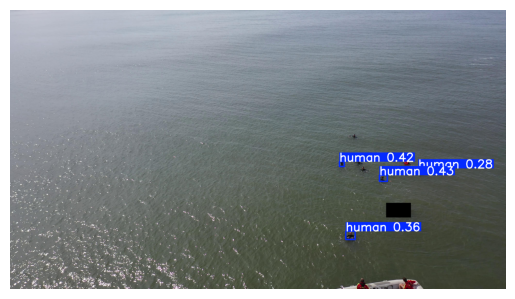

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 236 layers, 2,184,767 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 96.31it/s] 

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


                   all        200       1072      0.656      0.531      0.542      0.192


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 3.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799cebf75110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)